In [1]:
# ======================================================================
# MODULE TARGET : lightning_sim/sim/generator.py
# ----------------------------------------------------------------------
# This notebook cell refactors the original
# “Lightning‑storm generator 2.4 – single‑RNG, fully reproducible”
# into a *reusable* StormGenerator class.
#
# Quick test inside the notebook:
# >>> cfg = StormConfig()          # accept defaults or tweak fields
# >>> gen = StormGenerator(cfg)
# >>> bundle = gen.generate()
# >>> bundle.df_wave.head()
#
# When you migrate to a package:
#   1. Move this code into lightning_sim/sim/generator.py
#   2. Delete the inline StormConfig definition and instead
#      `from lightning_sim.config import StormConfig`
#   3. Make sure scipy is in your requirements.
# ======================================================================

from dataclasses import dataclass
from typing import Dict, List
import math, numpy as np, pandas as pd
from scipy.signal import butter, filtfilt

# ----------------------------------------------------------------------
# Configuration  (inline for notebook; later import from config.py)
# ----------------------------------------------------------------------
@dataclass(frozen=True)
class StormConfig:
    seed: int = 424242
    duration_min: int = 5
    scenario: str = 'medium'           # 'near' | 'medium' | 'far'
    difficulty: int = 1                # 1 … 9
    snr_db: float = 1.0               # –18 … +24 dB
    fs: int = 109_375                  # Sampling rate (Hz)
    bits: int = 14
    vref: float = 1.0

# ----------------------------------------------------------------------
# Return container
# ----------------------------------------------------------------------
@dataclass
class StormBundle:
    quantised: Dict[str, np.ndarray]
    events: List[dict]
    stroke_records: List[dict]
    df_wave: pd.DataFrame
    df_labels: pd.DataFrame

# ----------------------------------------------------------------------
# Storm generator
# ----------------------------------------------------------------------
class StormGenerator:
    """Generates a fully‑synthetic, reproducible lightning storm."""
    _stations = {  # static table copied from notebook
        'KEF': dict(lat=64.020, lon=-22.567),  'VAL': dict(lat=51.930, lon=-10.250),
        'LER': dict(lat=60.150, lon= -1.130),  'HER': dict(lat=50.867, lon=  0.336),
        'GIB': dict(lat=36.150, lon= -5.350),  'AKR': dict(lat=34.588, lon= 32.986),
        'CAM': dict(lat=50.217, lon= -5.317),  'WAT': dict(lat=52.127, lon=  0.956),
        'CAB': dict(lat=51.970, lon=  4.930),  'PAY': dict(lat=46.820, lon=  6.950),
        'TAR': dict(lat=58.263, lon= 26.464),
    }
    _STN = list(_stations)

    # ---------- helpers --------------------------------------------------
    @staticmethod
    def _hav(lat1, lon1, lat2, lon2):
        R = 6371.0
        φ1, φ2 = map(math.radians, (lat1, lat2))
        dφ, dλ = math.radians(lat2-lat1), math.radians(lon2-lon1)
        a = math.sin(dφ/2)**2 + math.cos(φ1)*math.cos(φ2)*math.sin(dλ/2)**2
        return 2*R*math.asin(math.sqrt(a))

    @staticmethod
    def _path_loss(dist_km: float) -> float:
        loss = (100/(dist_km + 100))**0.85 * math.exp(-0.0001*dist_km)
        if dist_km > 600:
            loss *= math.sqrt(2)
        return loss

    # --------------------------------------------------------------------
    def __init__(self, cfg: StormConfig):
        self.cfg = cfg
        self.rng = np.random.default_rng(cfg.seed)

    # --------------------------------------------------------------------
    def _difficulty_flags(self) -> Dict[str, bool]:
        d = self.cfg.difficulty
        return dict(
            ic_mix         = d >= 2,  multipath      = d >= 3,
            coloured_noise = d >= 4,  rfi_tones      = d >= 5,
            impulsive_rfi  = d >= 6,  sprite_ring    = d >= 5,
            false_transient= d >= 6,  clipping       = d >= 5,
            multi_cell     = d >= 6,  skywave        = d >= 7,
            sferic_bed     = d >= 7,  clock_skew     = d >= 8,
            gain_drift     = d >= 8,  dropouts       = d >= 8,
            low_snr        = d >= 9,  burst_div      = d >= 9,
        )

    # --------------------------------------------------------------------
    def _make_burst(self, dist_km: float, cg: bool, flags, SNR_lin, tv40, FS):
        rng, wave_len = self.rng, len(tv40)
        if flags['burst_div'] and rng.random() < 0.15:
            τ = 0.0008
            burst = (tv40/τ) * np.exp(1 - tv40/τ)
        else:
            f0 = rng.uniform(3e3, 15e3)
            τ  = rng.uniform(0.00025, 0.001 if cg else 0.0005)
            burst = np.sin(2*math.pi*f0*tv40) * np.exp(-tv40/τ)

        Vpeak = (0.15 if cg else 0.06)
        Vpeak *= self._path_loss(dist_km) / self._path_loss(100.0)
        Vpeak *= 10**(rng.uniform(-3, 3)/20) * SNR_lin
        if flags['low_snr']:
            Vpeak *= 0.5
        burst *= Vpeak / (np.abs(burst).max() + 1e-12)

        if flags['multipath'] and dist_km > 80 and rng.random() < 0.6:
            dly = int(rng.uniform(0.001, 0.004) * FS)
            if dly < wave_len:
                burst[dly:] += 0.35 * burst[:-dly]
        if flags['sprite_ring'] and rng.random() < 0.05:
            dly = int(rng.uniform(0.008, 0.018) * FS)
            if dly < wave_len:
                burst[dly:] += 0.25 * burst[:-dly]
        if flags['skywave'] and dist_km > 600:
            f = np.fft.rfftfreq(wave_len, 1/FS)
            H = np.exp(-0.00030*dist_km * (f/7e3)**2)
            burst = np.fft.irfft(np.fft.rfft(burst)*H, n=wave_len)

        return burst.astype(np.float32)

    # --------------------------------------------------------------------
    def generate(self) -> StormBundle:
        cfg, rng = self.cfg, self.rng
        FS = cfg.fs
        flags = self._difficulty_flags()

        # ----- timeline ---------------------------------------------------
        pre_sec   = rng.uniform(5, 30)
        storm_sec = cfg.duration_min * 60
        N         = int((pre_sec + storm_sec) * FS)

        quantised       = {nm: np.zeros(N, np.int16) for nm in self._STN}
        events, stroke_records, burst_book = [], [], []

        # ----- storm cells ------------------------------------------------
        lat_v = np.fromiter((s['lat'] for s in self._stations.values()), float)
        lon_v = np.fromiter((s['lon'] for s in self._stations.values()), float)
        lat_box = (lat_v.min()-0.9, lat_v.max()+0.9)
        lon_box = (lon_v.min()-1.5, lon_v.max()+1.5)
        new_cell = lambda: dict(lat=rng.uniform(*lat_box),
                                lon=rng.uniform(*lon_box),
                                drift=rng.uniform(-0.30, 0.30, 2))
        cells = [new_cell() for _ in range(1 if not flags['multi_cell']
                                           else rng.integers(2, 5))]
        R0_km = dict(near=120, medium=400, far=1000)[cfg.scenario]

        # ----- waveform library ------------------------------------------
        wave_len = int(0.04 * FS)
        tv40     = np.arange(wave_len) / FS
        SNR_lin  = 10**(cfg.snr_db/20)

        # ----- flash scheduler -------------------------------------------
        λ_flash = dict(near=8, medium=4, far=2)[cfg.scenario]*(1+0.4*cfg.difficulty)
        flash_ts, eid = pre_sec, 0

        while flash_ts < pre_sec + storm_sec:
            flash_ts += rng.exponential(60/λ_flash)
            if flash_ts >= pre_sec + storm_sec:
                break
            eid += 1

            cell  = rng.choice(cells)
            age_h = (flash_ts - pre_sec) / 3600
            f_lat = cell['lat'] + cell['drift'][0]*age_h
            f_lon = cell['lon'] + cell['drift'][1]*age_h
            r_km, θ = rng.uniform(0, R0_km), rng.uniform(0, 2*math.pi)
            f_lat += (r_km/111)*math.cos(θ)
            f_lon += (r_km/111)*math.sin(θ)/math.cos(math.radians(f_lat))

            f_type = 'IC' if (flags['ic_mix'] and rng.random() < 0.35) else 'CG'
            n_str  = rng.integers(1, 4 if f_type == 'IC' else 6)
            gaps   = rng.exponential(0.008, n_str)
            s_times = [flash_ts + float(gaps[:i+1].sum()) for i in range(n_str)]

            events.append(dict(id=eid, flash_type=f_type, lat=f_lat, lon=f_lon,
                               stroke_times=s_times))

            for si, t0 in enumerate(s_times):
                for nm in self._STN:
                    dist = self._hav(f_lat, f_lon,
                                     self._stations[nm]['lat'], self._stations[nm]['lon'])
                    idx  = int((t0 + dist/300_000 + rng.normal(0, 40e-6)) * FS)
                    if idx >= N - wave_len:
                        continue
                    burst = self._make_burst(dist, cg=(f_type == 'CG'), flags=flags,
                                             SNR_lin=SNR_lin, tv40=tv40, FS=FS)
                    burst_book.append((nm, idx, burst))
                    stroke_records.append(dict(event_id=eid, stroke_i=si, station=nm,
                                               flash_type=f_type, lat=f_lat, lon=f_lon,
                                               true_time_s=t0, sample_idx=idx,
                                               window_idx=idx//1024))

        # ----- noise & ADC synthesis -------------------------------------
        rfi_tones = [14_400, 20_100, 30_300]
        b, a      = butter(4, 45_000/(FS/2), 'low')
        chunk     = int(20*FS); tv_wave = tv40

        for nm in self._STN:
            bursts = [(i0, br) for st, i0, br in burst_book if st == nm]
            cfg_noise = dict(
                white=rng.uniform(0.010, 0.018),
                hum=rng.uniform(0.006, 0.020) if flags['coloured_noise'] else 0.01,
                tones=[] if not flags['rfi_tones'] else
                      [(rng.choice(rfi_tones), rng.uniform(0.001, 0.004))],
                gain_drift=rng.uniform(-0.05, 0.05) if flags['gain_drift'] else 0.0,
                skew=rng.uniform(-25e-6, 25e-6) if flags['clock_skew'] else 0.0
            )

            drop = np.ones(N, bool)
            if flags['dropouts'] and rng.random() < 0.1:
                for _ in range(rng.integers(1, 3)):
                    s = rng.integers(int(pre_sec*FS), N - int(0.4*FS))
                    drop[s:s+int(0.4*FS)] = False

            for s0 in range(0, N, chunk):
                e0 = min(N, s0 + chunk)
                L  = e0 - s0
                t  = np.arange(s0, e0) / FS * (1 + cfg_noise['skew'])

                seg = (cfg_noise['white'] * rng.standard_normal(L) +
                       cfg_noise['hum']   * np.sin(2*math.pi*50*t))
                for f, amp in cfg_noise['tones']:
                    seg += amp * np.sin(2*math.pi*f*t + rng.uniform(0, 2*math.pi))
                if flags['sferic_bed']:
                    seg += 0.0008 * rng.standard_normal(L)

                seg *= 1 + cfg_noise['gain_drift'] * (t - pre_sec) / (storm_sec + 1e-6)

                for i0, br in bursts:
                    if s0 <= i0 < e0:
                        off = i0 - s0
                        seg[off:off+wave_len] += br[:min(wave_len, L-off)]

                if flags['impulsive_rfi'] and rng.random() < 0.002:
                    p = rng.integers(0, L-200)
                    seg[p:p+200] += rng.uniform(-0.9, 0.9) * np.hanning(200)
                if flags['false_transient'] and rng.random() < 0.003:
                    p = rng.integers(0, L-wave_len)
                    seg[p:p+wave_len] += (0.6*np.sin(2*math.pi*5800*tv_wave) *
                                          np.exp(-tv_wave/0.0009))

                seg = filtfilt(b, a, seg)
                if flags['clipping']:
                    seg = np.clip(seg, -0.9*cfg.vref, 0.9*cfg.vref)
                full = 2**(cfg.bits-1) - 1
                adc  = np.clip(np.round(seg/cfg.vref*full), -full, full).astype(np.int16)
                quantised[nm][s0:e0][drop[s0:e0]] = adc[drop[s0:e0]]

        # ----- DataFrames & summary --------------------------------------
        df_wave = pd.DataFrame({'time_s': np.arange(N)/FS})
        for nm in self._STN:
            df_wave[nm] = quantised[nm]
        df_labels = pd.DataFrame(stroke_records)

        print(f"Tier-{cfg.difficulty}  SNR={cfg.snr_db:+.1f} dB  scenario={cfg.scenario}"
              f"  cells={len(cells)}")
        print(f"Flashes {len(events):3d} | strokes "
              f"{len(df_labels)//len(self._STN):3d} | samples {N:,}")

        return StormBundle(quantised, events, stroke_records, df_wave, df_labels)

# ----------------------------------------------------------------------
# Example quick run (will execute when you run this cell)
# ----------------------------------------------------------------------
if __name__ == "__main__":
    cfg = StormConfig()          # default parameters
    gen = StormGenerator(cfg)
    storm_data = gen.generate()


Tier-1  SNR=+1.0 dB  scenario=medium  cells=1
Flashes  18 | strokes  49 | samples 34,657,100


In [2]:
cfg

StormConfig(seed=424242, duration_min=5, scenario='medium', difficulty=1, snr_db=1.0, fs=109375, bits=14, vref=1.0)

In [12]:
# ======================================================================
# MODULE TARGET : lightning_sim/features/basic.py
# ----------------------------------------------------------------------
# Minimal feature infrastructure usable by any model
# (copy this entire cell into your notebook for now;
#  drop into `features/basic.py` when you move to a package.)
# ======================================================================

import numpy as np
from scipy.signal import hilbert, welch
from scipy.stats import kurtosis, skew
from typing import Callable, Dict, List

# ----------------------------------------------------------------------
# 1. Sliding‑window helper  (STRICTLY NO DUPLICATES ANYWHERE ELSE)
# ----------------------------------------------------------------------
def make_windows(sig: np.ndarray, win: int, hop: int) -> np.ndarray:
    """Return (n_windows, win) view onto *sig* with stride *hop*."""
    n = (len(sig) - win) // hop + 1
    idx = np.arange(0, n * hop, hop)[:, None] + np.arange(win)
    return sig[idx]

# ----------------------------------------------------------------------
# 2. Tiny registry of feature functions
# ----------------------------------------------------------------------
_feature_funcs: Dict[str, Callable[[np.ndarray, Dict], np.ndarray]] = {}

def register_feature(name: str):
    """Decorator: register a feature function under *name*."""
    def _wrap(func):
        _feature_funcs[name] = func
        return func
    return _wrap

def list_features() -> List[str]:
    return sorted(_feature_funcs)

# ----------------------------------------------------------------------
# 3. Example feature functions
# ----------------------------------------------------------------------
@register_feature("hilbert_peak")
def feat_hilbert_peak(win_mat: np.ndarray, ctx: Dict) -> np.ndarray:
    """Max of Hilbert envelope per window → shape (n,1)."""
    env = np.abs(hilbert(win_mat.astype(float), axis=1))
    return env.max(axis=1, keepdims=True)

@register_feature("rms_db")
def feat_rms_db(win_mat: np.ndarray, ctx: Dict) -> np.ndarray:
    rms = np.sqrt((win_mat.astype(float)**2).mean(axis=1)) + 1e-9
    return (20 * np.log10(rms)).reshape(-1, 1)

@register_feature("spectral_entropy")
def feat_spec_entropy(win_mat: np.ndarray, ctx: Dict) -> np.ndarray:
    fs = ctx["fs"]
    out = np.empty((win_mat.shape[0], 1))
    for i, w in enumerate(win_mat):
        f, P = welch(w, fs, nperseg=256)
        P /= P.sum() + 1e-9
        out[i, 0] = -np.sum(P * np.log(P + 1e-9))
    return out

@register_feature("env_kurtosis")
def feat_env_kurt(win_mat: np.ndarray, ctx: Dict) -> np.ndarray:
    env = np.abs(hilbert(win_mat.astype(float), axis=1))
    return kurtosis(env, axis=1).reshape(-1, 1)


# ======================================================================
# Registry extension – 13‑dim feature vector for Isolation‑Forest
# ----------------------------------------------------------------------
# Adds "iso13" to the existing feature registry.
# You only need to run this cell ONCE in the notebook.
# ======================================================================

import numpy as np, math, zlib, pywt
from scipy.signal import hilbert
from typing import Dict

@register_feature("iso13")
def feat_iso13(win_mat: np.ndarray, ctx: Dict) -> np.ndarray:
    """
    Return (n, 13) feature matrix per window.
    Features (per original inline code):
      0  peak_env      – max Hilbert envelope
      1  med_env       – median Hilbert envelope
      2  ratio_env     – peak / median
      3  energy        – Σ x²
      4  sta_lta       – 128‑/1024‑sample STA/LTA on envelope
      5  crest_short   – crest factor on centre ⅛ of window
      6  crest_global  – peak_env / RMS
      7‑10 frac1‑4     – FFT power quartiles
     11  wave_hi       – wavelet (db4) high‑band energy ratio
     12  comp_ratio    – zlib compression ratio (bytes)
    """
    n, W = win_mat.shape
    env   = np.abs(hilbert(win_mat.astype(float), axis=1))
    Nfft  = W//2 + 1
    b25,b50,b75 = [int(Nfft*r) for r in (0.25,0.50,0.75)]
    out = np.empty((n, 13), float)

    def _sta_lta(x, sta=128, lta=1024):
        c=len(x)//2
        return x[c-sta//2:c+sta//2].mean()/(x[c-lta//2:c+lta//2].mean()+1e-9)
    def _crest(seg):
        n=len(seg)//8; c=len(seg)//2
        part=seg[c-n//2:c+n//2].astype(float)
        return np.abs(part).max()/(math.sqrt((part**2).mean())+1e-9)
    _comp = lambda v: len(zlib.compress(v.tobytes(),6))/len(v.tobytes())

    for i,(seg_i16, env_seg) in enumerate(zip(win_mat,env)):
        seg_f = seg_i16.astype(float)
        peak  = env_seg.max(); med = np.median(env_seg)
        P = np.abs(np.fft.rfft(seg_f))**2; totP=P.sum()+1e-9
        hi = pywt.wavedec(seg_f,'db4',level=3)[1]
        lo = pywt.wavedec(seg_f,'db4',level=3)[-1]
        out[i] = [
            peak, med, peak/(med+1e-9),
            (seg_f**2).sum(), _sta_lta(env_seg),
            _crest(seg_i16), peak/(math.sqrt((seg_f**2).mean())+1e-9),
            P[:b25].sum()/totP, P[b25:b50].sum()/totP,
            P[b50:b75].sum()/totP, P[b75:].sum()/totP,
            (hi**2).sum()/((hi**2).sum()+(lo**2).sum()+1e-9),
            _comp(seg_i16)
        ]
    return out

# ======================================================================
# Registry extension – "ae10"  (10‑dim node‑level feature block)
# ----------------------------------------------------------------------
# Run once; makes the feature available to any future model.
# ======================================================================

import numpy as np, math
from scipy.signal import hilbert
from typing import Dict

@register_feature("ae10")
def feat_ae10(win_mat: np.ndarray, ctx: Dict) -> np.ndarray:
    """
    10 scalars per window (matches original 'feats10'):
        0  peak_env           5  sta/lta 128/whole
        1  median_env         6  FFT band 0‑25 %
        2  peak / median      7  FFT band 25‑50 %
        3  RMS                8  FFT band 50‑75 %
        4  peak / RMS         9  FFT band 75‑100 %
    """
    env = np.abs(hilbert(win_mat.astype(float), axis=1))
    n, W = win_mat.shape
    out  = np.empty((n, 10), float)
    Nfft = W//2 + 1
    b25,b50,b75 = [int(Nfft*r) for r in (0.25,0.50,0.75)]

    def _sta_lta(e):
        return e[:256].mean() / (e.mean() + 1e-9)

    for i, (seg, e) in enumerate(zip(win_mat, env)):
        peak, med = e.max(), np.median(e)
        rms  = math.sqrt((seg.astype(float)**2).mean()+1e-9)
        P    = np.abs(np.fft.rfft(seg.astype(float)))**2
        totP = P.sum()+1e-9
        frac = [P[:b25].sum()/totP, P[b25:b50].sum()/totP,
                P[b50:b75].sum()/totP, P[b75:].sum()/totP]
        out[i] = [peak, med, peak/(med+1e-9),
                  rms, peak/(rms+1e-9), _sta_lta(e), *frac]
    return out


# ======================================================================
# Registry extension – "iso16"  (16‑dim Isolation‑Forest features)
# ----------------------------------------------------------------------
# Run once; adds the feature function to the shared registry.
# ======================================================================

import numpy as np, math, zlib, pywt
from scipy.signal import hilbert
from typing import Dict

@register_feature("iso16")
def feat_iso16(win_mat: np.ndarray, ctx: Dict) -> np.ndarray:
    """
    16‑dim features per window (matches the latest inline list):
      0  peak_env          8  band2
      1  med_env           9  band3
      2  ratio_env        10  band4
      3  energy           11  wave_hi
      4  sta_lta          12  comp_ratio
      5  crest_short      13  spec_centroid
      6  crest_global     14  spec_bandwidth
      7  band1            15  spec_entropy
    """
    fs = ctx["fs"]
    n, W = win_mat.shape
    env  = np.abs(hilbert(win_mat.astype(float), axis=1))
    Nf   = W//2 + 1
    b25,b50,b75 = [int(Nf*r) for r in (0.25,0.50,0.75)]
    out = np.empty((n, 16), float)

    def _sta_lta(x, s=128, l=1024):
        c=len(x)//2
        return x[c-s//2:c+s//2].mean()/(x[c-l//2:c+l//2].mean()+1e-9)
    def _crest(seg):
        return np.abs(seg).max()/(math.sqrt((seg.astype(float)**2).mean())+1e-9)
    _comp = lambda v: len(zlib.compress(v.tobytes(),6))/len(v.tobytes())

    for i,(seg_i16, env_seg) in enumerate(zip(win_mat, env)):
        seg_f = seg_i16.astype(float)
        peak, med = env_seg.max(), np.median(env_seg)
        P = np.abs(np.fft.rfft(seg_f))**2
        totP = P.sum()+1e-9
        frac = [P[:b25].sum()/totP, P[b25:b50].sum()/totP,
                P[b50:b75].sum()/totP, P[b75:].sum()/totP]
        hi = pywt.wavedec(seg_f,'db4',level=3)[1]
        lo = pywt.wavedec(seg_f,'db4',level=3)[-1]
        wave_hi = (hi**2).sum()/((hi**2).sum()+(lo**2).sum()+1e-9)
        freqs = np.fft.rfftfreq(len(seg_f), d=1/fs)
        Pn = P/totP
        centroid = (freqs*Pn).sum()
        bandwidth= math.sqrt(((freqs-centroid)**2*Pn).sum())
        entropy  = -(Pn*np.log2(Pn+1e-12)).sum()

        out[i] = [
            peak, med, peak/(med+1e-9),
            (seg_f**2).sum(), _sta_lta(env_seg),
            _crest(seg_i16[len(seg_i16)//2-W//16:len(seg_i16)//2+W//16]),
            _crest(seg_i16),
            *frac, wave_hi, _comp(seg_i16),
            centroid, bandwidth, entropy
        ]
    return out



# ----------------------------------------------------------------------
# 4. FeatureExtractor  (works for ANY model)
# ----------------------------------------------------------------------
class FeatureExtractor:
    """
    Simple, stateless extractor.

    Example
    -------
    >>> fx = FeatureExtractor(["hilbert_peak", "rms_db"])
    >>> X_stn, n_win = fx.transform(raw_signals, win=1024, hop=512, fs=109_375)
    """
    def __init__(self, feat_names: List[str]):
        missing = [n for n in feat_names if n not in _feature_funcs]
        if missing:
            raise ValueError(f"Unknown features: {missing}")
        self.names = feat_names

    def transform(self,
                  raw_signals: Dict[str, np.ndarray],
                  *,
                  win: int,
                  hop: int,
                  fs: int) -> (Dict[str, np.ndarray], int):
        ctx = dict(fs=fs)
        mats = {}
        n_win_min = None
        for nm, sig in raw_signals.items():
            win_mat = make_windows(sig, win, hop)
            parts = [ _feature_funcs[n](win_mat, ctx) for n in self.names ]
            mats[nm] = np.hstack(parts)
            n_win_min = mats[nm].shape[0] if n_win_min is None \
                        else min(n_win_min, mats[nm].shape[0])
        # ensure all stations have same number of windows
        mats = {nm: X[:n_win_min] for nm, X in mats.items()}
        return mats, n_win_min


In [13]:
# ======================================================================
# Evaluation utilities  (full‑feature version)
# ----------------------------------------------------------------------
# Defines:
#   • EvalConfig          – all timing & tolerance knobs, plus fs
#   • evaluate_windowed_model()
# ----------------------------------------------------------------------

from dataclasses import dataclass
from typing import Dict, List
import numpy as np, matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score
)

# ----------------------------------------------------------------------
# 1.  Timing / tolerance configuration
# ----------------------------------------------------------------------
@dataclass
class EvalConfig:
    win: int        = 1024
    hop: int        = 512
    fs: int         = 109_375   # Hz
    burst_len: int  = None      # default = 0.04 * fs (filled below)
    min_stn: int    = 2
    tol_win: int    = 0         # dilation (0 = strict)

    def __post_init__(self):
        if self.burst_len is None:
            object.__setattr__(self, "burst_len", int(0.04 * self.fs))

# ----------------------------------------------------------------------
# 2.  Main evaluation routine
# ----------------------------------------------------------------------
def evaluate_windowed_model(
    *,
    hot: Dict[str, np.ndarray],
    stroke_records: List[dict],
    quantized: Dict[str, np.ndarray],
    station_order: List[str],
    win: int | None = None,
    hop: int | None = None,
    fs:  int | None = None,
    burst_len: int | None = None,
    min_stn: int | None = None,
    tol_win: int | None = None,
    cfg: EvalConfig | None = None,
    plot: bool = True,
):
    """
    Evaluate per‑station *hot* window flags against ground‑truth strokes.

    Parameters
    ----------
    You may EITHER pass `cfg=EvalConfig(...)` **or** the individual knobs
    (`win`, `hop`, `fs`, `burst_len`, …).  Mixing is fine; cfg overrides.
    """
    # ---- resolve config -------------------------------------------------
    if cfg is not None:
        win       = cfg.win
        hop       = cfg.hop
        fs        = cfg.fs
        burst_len = cfg.burst_len
        min_stn   = cfg.min_stn
        tol_win   = cfg.tol_win
    else:   # legacy / ad‑hoc style
        win       = win or 1024
        hop       = hop or win // 2
        fs        = fs  or 109_375
        burst_len = burst_len or int(0.04 * fs)
        min_stn   = min_stn or 2
        tol_win   = tol_win or 0

    n_win = min((len(quantized[s]) - win) // hop + 1 for s in station_order)
    if n_win <= 0:
        raise RuntimeError("No complete windows to score.")

    # ---------- 1) ground truth -----------------------------------------
    station_truth = {s: np.zeros(n_win, bool) for s in station_order}
    stroke_to_winset = defaultdict(lambda: defaultdict(set))

    for rec in stroke_records:
        s = rec["station"]
        if s not in station_order:
            continue
        s0 = rec["sample_idx"]; s1 = s0 + burst_len - 1
        w_first = max(0, (s0 - win + hop) // hop)
        w_last  = min(n_win - 1,  s1 // hop)
        station_truth[s][w_first:w_last+1] = True
        key = (rec["event_id"], rec.get("stroke_i", 0))
        stroke_to_winset[key][s].update(range(w_first, w_last+1))

    # ---------- 2) predictions (+ optional dilation) --------------------
    ker = np.ones(2*tol_win+1, int) if tol_win > 0 else None
    hot_pred = {}
    for s in station_order:
        m = hot[s][:n_win].astype(bool)
        if ker is not None:
            m = np.convolve(m.astype(int), ker, mode="same") > 0
        hot_pred[s] = m

    # ---------- 3) per‑station metrics ----------------------------------
    def _metrics(y_true, y_pred):
        tn, fp, fn, tp = confusion_matrix(
            y_true, y_pred, labels=[False, True]).ravel()
        return dict(
            TP=int(tp), FP=int(fp), FN=int(fn), TN=int(tn),
            P=float(f"{precision_score(y_true,y_pred,zero_division=0):.3f}"),
            R=float(f"{recall_score   (y_true,y_pred,zero_division=0):.3f}"),
            F1=float(f"{f1_score      (y_true,y_pred,zero_division=0):.3f}")
        )
    station_metrics = {s: _metrics(station_truth[s], hot_pred[s])
                       for s in station_order}

    # ---------- 4) stroke‑level / network metrics -----------------------
    tp = fn = 0; matched = set()
    stroke_hits = {}
    for key, per_stn in stroke_to_winset.items():
        hits = sum(any(hot_pred[s][w] for w in ws)
                   for s, ws in per_stn.items())
        stroke_hits[key] = hits
        if hits >= min_stn:
            tp += 1; matched.update(*per_stn.values())
        else:
            fn += 1

    counts = sum(hot_pred[s] for s in station_order)
    fp_mask = counts >= min_stn
    fp = 0; in_cl = False
    fp_windows = []
    for w, flag in enumerate(fp_mask):
        if flag and w not in matched and not in_cl:
            fp += 1; fp_windows.append(w); in_cl = True
        elif not flag: in_cl = False

    P_net = tp/(tp+fp) if tp+fp else 0
    R_net = tp/(tp+fn) if tp+fn else 0
    F1_net= 2*P_net*R_net/(P_net+R_net) if P_net+R_net else 0
    network_metrics = dict(
        TP=tp, FP=fp, FN=fn, TN=0,
        P=float(f"{P_net:.3f}"), R=float(f"{R_net:.3f}"), F1=float(f"{F1_net:.3f}")
    )

    # ---------- 5) visualisation ---------------------------------------
    if plot:
        # timeline
        fig, ax = plt.subplots(figsize=(12, 2.5))
        ax.set_facecolor("#202020"); fig.patch.set_facecolor("#202020")
        for key, per_stn in stroke_to_winset.items():
            x = min(min(ws) for ws in per_stn.values())
            col = "#ffffff" if stroke_hits[key] >= min_stn else "#ffa500"
            ax.axvline(x, color=col, lw=1.4)
        for w in fp_windows:
            ax.axvline(w, color="#ff1744", lw=1.4)
        ax.set_yticks([]); ax.set_xlabel("Window index")
        ax.set_title("Stroke timeline   –   white TP   |   amber FN   |   red FP")
        plt.tight_layout(); plt.show()

        # waveform snippets (first TP / FP / FN)
        def _first(cand): return min(cand, key=lambda t:t[1]) if cand else None
        tp_cand = [(s, np.flatnonzero(station_truth[s] & hot_pred[s]))
                   for s in station_order]
        tp_win  = _first([(s, arr[0]) for s, arr in tp_cand if arr.size])

        fp_cand = [(s, np.flatnonzero(~station_truth[s] & hot_pred[s]))
                   for s in station_order]
        fp_win  = _first([(s, arr[0]) for s, arr in fp_cand if arr.size])

        fn_win = None
        if fn:
            for key, per_stn in stroke_to_winset.items():
                if stroke_hits[key] < min_stn:
                    st = next(iter(per_stn))
                    fn_win = (st, min(per_stn[st])); break

        if any([tp_win, fp_win, fn_win]):
            fig2, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
            t_axis = np.arange(win) / fs * 1e3  # ms
            def _panel(ax, win_tup, title_ok, title_none):
                if win_tup:
                    s,w = win_tup; beg=w*hop
                    ax.plot(t_axis, quantized[s][beg:beg+win])
                    ax.set_title(title_ok.format(s,w))
                else:
                    ax.set_title(title_none)
            _panel(axes[0], tp_win, "First TP — {} win#{}", "No true positives")
            _panel(axes[1], fp_win, "First FP — {} win#{}", "No false positives")
            _panel(axes[2], fn_win, "First FN — {} win#{}", "No false negatives")
            axes[-1].set_xlabel("Time in window (ms)")
            plt.tight_layout(); plt.show()

    return station_metrics, network_metrics, n_win


Per‑station thresholds & flagged windows:
 KEF: thr= 673.27, flagged=   68 / 67688
 VAL: thr= 661.49, flagged=   68 / 67688
 LER: thr= 691.00, flagged=   68 / 67688
 HER: thr= 723.52, flagged=   68 / 67688
 GIB: thr= 815.94, flagged=   68 / 67688
 AKR: thr= 575.56, flagged=   68 / 67688
 CAM: thr= 574.67, flagged=   68 / 67688
 WAT: thr= 575.03, flagged=   68 / 67688
 CAB: thr= 581.95, flagged=   68 / 67688
 PAY: thr= 632.62, flagged=   68 / 67688
 TAR: thr= 652.44, flagged=   68 / 67688


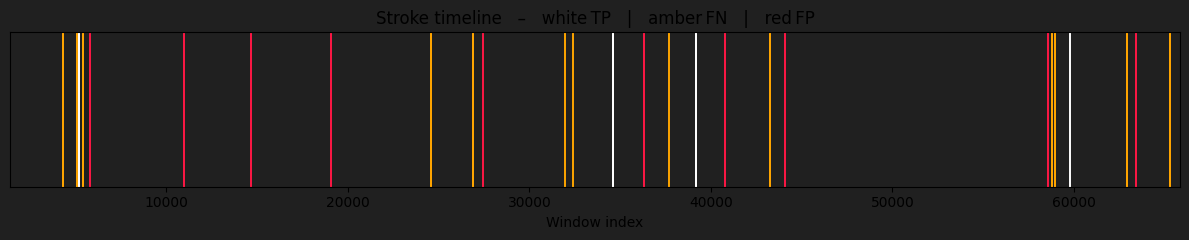

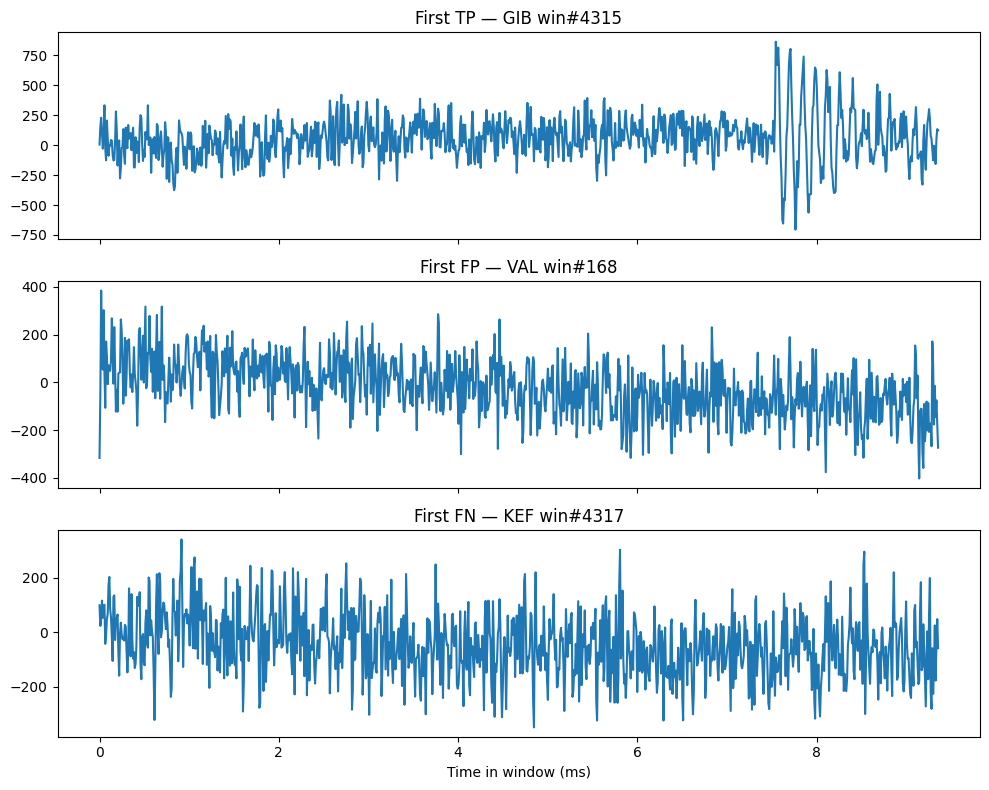


Per‑station metrics (strict timeline):
 KEF: TP=  0 FP= 68 FN=245  P=0.000 R=0.000 F1=0.000
 VAL: TP=  2 FP= 66 FN=243  P=0.029 R=0.008 F1=0.013
 LER: TP=  0 FP= 68 FN=244  P=0.000 R=0.000 F1=0.000
 HER: TP=  2 FP= 66 FN=242  P=0.029 R=0.008 F1=0.013
 GIB: TP= 56 FP= 12 FN=191  P=0.824 R=0.227 F1=0.356
 AKR: TP=  0 FP= 68 FN=245  P=0.000 R=0.000 F1=0.000
 CAM: TP= 11 FP= 57 FN=232  P=0.162 R=0.045 F1=0.071
 WAT: TP=  0 FP= 68 FN=246  P=0.000 R=0.000 F1=0.000
 CAB: TP=  1 FP= 67 FN=246  P=0.015 R=0.004 F1=0.006
 PAY: TP=  2 FP= 66 FN=242  P=0.029 R=0.008 F1=0.013
 TAR: TP=  0 FP= 68 FN=247  P=0.000 R=0.000 F1=0.000

Network‑level metrics: {'TP': 14, 'FP': 10, 'FN': 35, 'TN': 0, 'P': 0.583, 'R': 0.286, 'F1': 0.384}


In [14]:
# ======================================================================
# Hilbert‑envelope baseline – refactored (fits + evaluates)
# ----------------------------------------------------------------------
# Uses:
#   • storm_data         (already produced by StormGenerator.generate())
#   • FeatureExtractor   (registry cell, with "hilbert_peak")
#   • EvalConfig + evaluate_windowed_model  (evaluator cell)
# ======================================================================

# ------------ 0.  Shared values ---------------------------------------
FS   = cfg.fs                       # sample‑rate from the very same config
STN  = list(storm_data.quantised)   # deterministic station order
WIN, HOP = 1024, 512
PCT_THRESH = 99.9
MIN_STN    = 2
TOL_WIN    = 0

# ------------ 1.  Compute Hilbert‑peak per window ----------------------
fx   = FeatureExtractor(["hilbert_peak"])
peaks_dict, n_win = fx.transform(storm_data.quantised,
                                 win=WIN, hop=HOP, fs=FS)

# ------------ 2.  Per‑station thresholding ----------------------------
hot = {}
print("Per‑station thresholds & flagged windows:")
for nm in STN:
    pk = peaks_dict[nm][:, 0]                     # single‑column feature
    thr = np.percentile(pk, PCT_THRESH)
    mask = pk > thr
    hot[nm] = mask
    print(f" {nm}: thr={thr:7.2f}, flagged={mask.sum():5d} / {n_win}")

# ------------ 3.  Evaluation ------------------------------------------
eval_cfg = EvalConfig(win=WIN, hop=HOP, fs=FS,
                      burst_len=int(0.04*FS),
                      min_stn=MIN_STN, tol_win=TOL_WIN)

station_m, net_m, _ = evaluate_windowed_model(
    hot            = hot,
    stroke_records = storm_data.stroke_records,
    quantized      = storm_data.quantised,
    station_order  = STN,
    cfg            = eval_cfg,
    plot           = True          # timeline + waveform panels
)

# ------------ 4.  Summary printout ------------------------------------
print("\nPer‑station metrics (strict timeline):")
for nm, m in station_m.items():
    print(f" {nm}: TP={m['TP']:3d} FP={m['FP']:3d} "
          f"FN={m['FN']:3d}  P={m['P']:.3f} R={m['R']:.3f} F1={m['F1']:.3f}")

print("\nNetwork‑level metrics:", net_m)


/Users/johngoodacre/leela-ml/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



▶ Fitting NCD baselines & thresholds …
KEF: baseline#28617  thr=0.8683  hot=65
VAL: baseline#33919  thr=0.8824  hot=66
LER: baseline#33881  thr=0.8446  hot=120
HER: baseline#63010  thr=0.8645  hot=68
GIB: baseline#53060  thr=0.8621  hot=67
AKR: baseline#14420  thr=0.8269  hot=193
CAM: baseline#23454  thr=0.8615  hot=68
WAT: baseline#17505  thr=0.8725  hot=65
CAB: baseline#61775  thr=0.8440  hot=112
PAY: baseline#51484  thr=0.8883  hot=66
TAR: baseline#36492  thr=0.8696  hot=67

▶ Predicting hot windows …


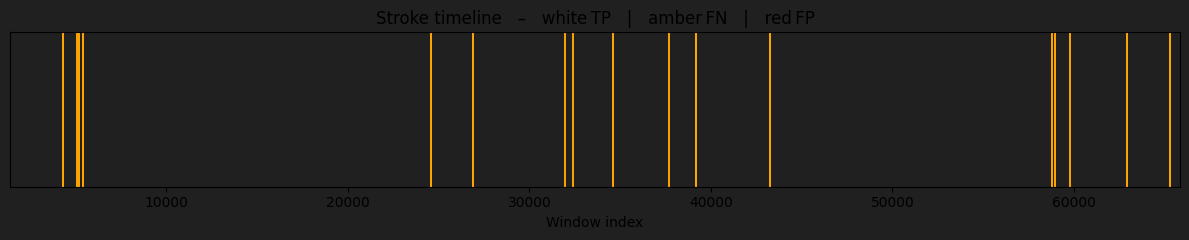

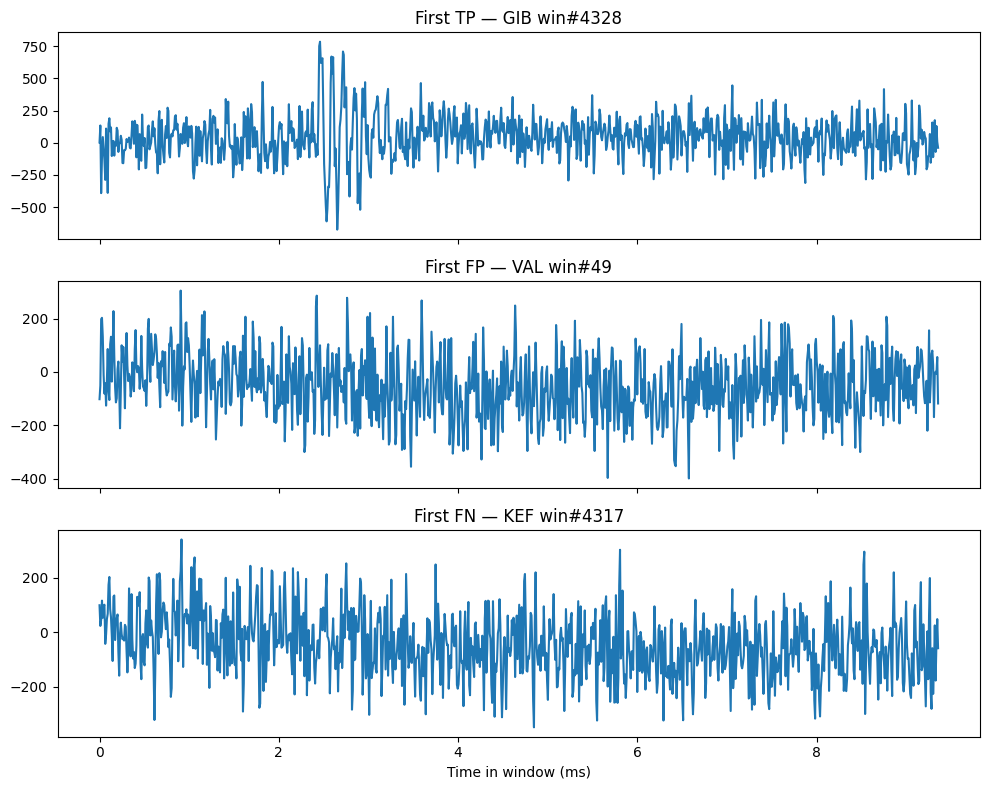


—— Station / window metrics  (n_windows = 67,688) ——
KEF: TP=0    FP=65    FN=245  P=0.000 R=0.000 F1=0.000
VAL: TP=0    FP=66    FN=245  P=0.000 R=0.000 F1=0.000
LER: TP=1    FP=119   FN=243  P=0.008 R=0.004 F1=0.005
HER: TP=0    FP=68    FN=244  P=0.000 R=0.000 F1=0.000
GIB: TP=3    FP=64    FN=244  P=0.045 R=0.012 F1=0.019
AKR: TP=0    FP=193   FN=245  P=0.000 R=0.000 F1=0.000
CAM: TP=0    FP=68    FN=243  P=0.000 R=0.000 F1=0.000
WAT: TP=2    FP=63    FN=244  P=0.031 R=0.008 F1=0.013
CAB: TP=0    FP=112   FN=247  P=0.000 R=0.000 F1=0.000
PAY: TP=0    FP=66    FN=244  P=0.000 R=0.000 F1=0.000
TAR: TP=0    FP=67    FN=247  P=0.000 R=0.000 F1=0.000

—— Network / stroke metrics ——
{'TP': 0, 'FP': 0, 'FN': 49, 'TN': 0, 'P': 0.0, 'R': 0.0, 'F1': 0.0}


In [6]:
# ======================================================================
# NCD‑baseline detector (model 2) – notebook implementation
# ----------------------------------------------------------------------
# Later, move the class to   lightning_sim/models/ncd_baseline.py
# and replace the commented import stubs with package paths.
# ======================================================================

# from lightning_sim.features.basic import make_windows
# from lightning_sim.evaluation.scorer import evaluate_windowed_model, EvalConfig

import bz2, numpy as np
from functools import lru_cache
from tqdm.auto import trange

# ---------- 0.  helpers (tiny, no duplication) ------------------------
@lru_cache(maxsize=None)
def _c_size(b: bytes) -> int:            # compressed size
    return len(bz2.compress(b, 9))

def _ncd(a: bytes, b: bytes, Ca: int, Cb: int) -> float:
    return (_c_size(a+b) - min(Ca, Cb)) / max(Ca, Cb)

def _sign_bits(arr: np.ndarray) -> bytes:
    diff = np.diff(arr.astype(np.int16), prepend=arr[0])
    return np.packbits((diff > 0).astype(np.uint8)).tobytes()

# ---------- 1.  The detector class -----------------------------------
class NcdBaselineModel:
    """
    Parameters
    ----------
    win, hop   : sliding‑window length & hop (samples)
    base_pct   : % of *lowest‑entropy* windows used to pick the baseline
    pct_thr    : NCD percentile threshold (global)
    z_sigma    : μ + z σ alternative threshold (used with pct_thr = min)
    """
    def __init__(self, *,
                 win=1024, hop=512,
                 base_pct=5, pct_thr=99.9, z_sigma=3.5):
        self.win      = win
        self.hop      = hop
        self.base_pct = base_pct
        self.pct_thr  = pct_thr
        self.z_sigma  = z_sigma
        self.meta     = {}   # per‑station cache: baseline, threshold, etc.

    # ------------------------------------------------------------------
    def _fit_one(self, sig: np.ndarray):
        """Return (baseline_bits, Cb, threshold, hot_mask, stats_dict)."""
        win_mat = make_windows(sig, self.win, self.hop)
        n = win_mat.shape[0]

        # compressed size per window
        comp = np.empty(n, np.uint16)
        for i in range(n):
            comp[i] = _c_size(_sign_bits(win_mat[i]))

        # choose baseline = median window among lowest *base_pct* %
        k = max(1, int(self.base_pct/100 * n))
        idx_low = np.argpartition(comp, k)[:k]
        base_idx = idx_low[np.argsort(comp[idx_low])[k//2]]
        base_bits = _sign_bits(win_mat[base_idx])
        Cb = _c_size(base_bits)

        # NCD vector
        ncd_vec = np.empty(n, float)
        for i in range(n):
            wb = _sign_bits(win_mat[i])
            ncd_vec[i] = _ncd(wb, base_bits, comp[i], Cb)

        # thresholds
        thr_pct = np.percentile(ncd_vec, self.pct_thr)
        mu, sd = ncd_vec.mean(), ncd_vec.std(ddof=0)
        thr_z  = mu + self.z_sigma * sd
        thr    = min(thr_pct, thr_z)

        return base_bits, Cb, thr, ncd_vec > thr, dict(
            base_idx=base_idx, thr_pct=thr_pct, thr_z=thr_z,
            mu=mu, sd=sd)

    # ------------------------------------------------------------------
    def fit(self, raw_signals: dict[str, np.ndarray], verbose=True):
        """Compute baseline, thresholds, and hot masks for *training* data."""
        for nm, sig in raw_signals.items():
            bb, Cb, thr, hot, stat = self._fit_one(sig)
            self.meta[nm] = dict(base_bits=bb, Cb=Cb, thr=thr,
                                 stats=stat)
            if verbose:
                n_hot = int(hot.sum())
                print(f"{nm}: baseline#{stat['base_idx']}  "
                      f"thr={thr:.4f}  hot={n_hot:,}")

    # ------------------------------------------------------------------
    def predict(self, raw_signals: dict[str, np.ndarray]) -> dict[str, np.ndarray]:
        """Return {station → bool hot_mask} for *any* signals."""
        out = {}
        for nm, sig in raw_signals.items():
            if nm not in self.meta:
                raise ValueError(f"Station {nm} not fitted.")
            bb   = self.meta[nm]['base_bits']
            Cb   = self.meta[nm]['Cb']
            thr  = self.meta[nm]['thr']
            win_mat = make_windows(sig, self.win, self.hop)
            ncd_vec = np.empty(win_mat.shape[0], float)
            for i in range(len(ncd_vec)):
                wb = _sign_bits(win_mat[i])
                ncd_vec[i] = _ncd(wb, bb, _c_size(wb), Cb)
            out[nm] = ncd_vec > thr
        return out

# ---------- 2.  Train, predict, evaluate -------------------------------

WIN, HOP = 1024, 512
model2 = NcdBaselineModel(win=WIN, hop=HOP,
                          base_pct=5, pct_thr=99.9, z_sigma=3.5)

print("\n▶ Fitting NCD baselines & thresholds …")
model2.fit(storm_data.quantised, verbose=True)

print("\n▶ Predicting hot windows …")
hot2 = model2.predict(storm_data.quantised)

eval_cfg = EvalConfig(win=WIN, hop=HOP, fs=cfg.fs,
                      min_stn=2, tol_win=0)

station_m2, net_m2, n_win2 = evaluate_windowed_model(
    hot            = hot2,
    stroke_records = storm_data.stroke_records,
    quantized      = storm_data.quantised,
    station_order  = list(storm_data.quantised),
    cfg            = eval_cfg,
    plot           = True        # timeline + waveform panels
)

# ---------- 3.  Summary table -----------------------------------------
print(f"\n—— Station / window metrics  (n_windows = {n_win2:,}) ——")
for nm in storm_data.quantised:
    m = station_m2[nm]
    print(f"{nm}: TP={m['TP']:<4} FP={m['FP']:<5} FN={m['FN']:<4} "
          f"P={m['P']:.3f} R={m['R']:.3f} F1={m['F1']:.3f}")

print("\n—— Network / stroke metrics ——")
print(net_m2)



▶ Fitting Isolation‑Forest detectors …
KEF: windows flagged =    68 / 67688 (contam=0.100%)
VAL: windows flagged =    68 / 67688 (contam=0.100%)
LER: windows flagged =    68 / 67688 (contam=0.100%)
HER: windows flagged =    68 / 67688 (contam=0.100%)
GIB: windows flagged =    68 / 67688 (contam=0.100%)
AKR: windows flagged =    68 / 67688 (contam=0.100%)
CAM: windows flagged =    68 / 67688 (contam=0.100%)
WAT: windows flagged =    68 / 67688 (contam=0.100%)
CAB: windows flagged =    68 / 67688 (contam=0.100%)
PAY: windows flagged =    68 / 67688 (contam=0.100%)
TAR: windows flagged =    68 / 67688 (contam=0.100%)

▶ Predicting hot windows …


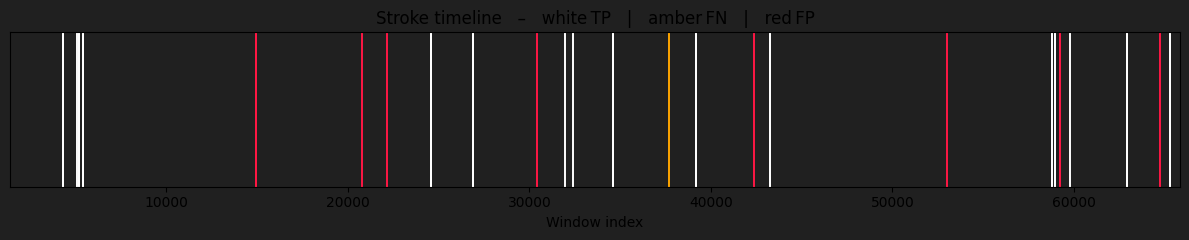

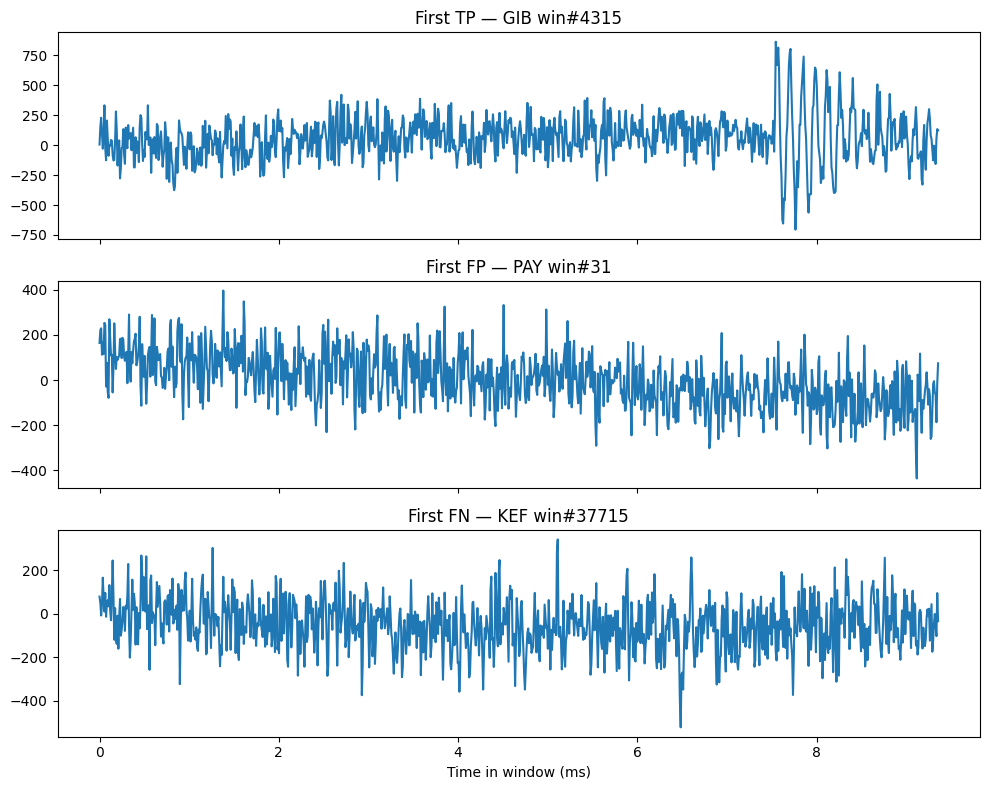


—— Station / window metrics  (n_windows = 67,688) ——
KEF: TP=  0 FP=  68 FN=245 P=0.000 R=0.000 F1=0.000
VAL: TP= 17 FP=  51 FN=228 P=0.250 R=0.069 F1=0.109
LER: TP=  1 FP=  67 FN=243 P=0.015 R=0.004 F1=0.006
HER: TP= 11 FP=  57 FN=233 P=0.162 R=0.045 F1=0.071
GIB: TP= 66 FP=   2 FN=181 P=0.971 R=0.267 F1=0.419
AKR: TP=  0 FP=  68 FN=245 P=0.000 R=0.000 F1=0.000
CAM: TP= 38 FP=  30 FN=205 P=0.559 R=0.156 F1=0.244
WAT: TP= 21 FP=  47 FN=225 P=0.309 R=0.085 F1=0.134
CAB: TP= 16 FP=  52 FN=231 P=0.235 R=0.065 F1=0.102
PAY: TP= 21 FP=  47 FN=223 P=0.309 R=0.086 F1=0.135
TAR: TP=  0 FP=  68 FN=247 P=0.000 R=0.000 F1=0.000

—— Network / stroke metrics ——
{'TP': 48, 'FP': 9, 'FN': 1, 'TN': 0, 'P': 0.842, 'R': 0.98, 'F1': 0.906}


In [8]:
# ======================================================================
# Isolation‑Forest detector – fit, predict, evaluate
# ----------------------------------------------------------------------
# Depends on:
#   • storm_data, cfg              (from StormGenerator cell)
#   • FeatureExtractor, make_windows (registry cell, now incl. "iso13")
#   • EvalConfig, evaluate_windowed_model (evaluator cell)
# ======================================================================

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from typing import Dict

class IsoForestModel:
    def __init__(self, *, win=1024, hop=512,
                 contamination=0.001, n_trees=150, random_state=42):
        self.win = win; self.hop = hop
        self.contam = contamination
        self.n_trees = n_trees
        self.rs = random_state
        self.fx = FeatureExtractor(["iso13"])
        self.models: Dict[str, tuple] = {}  # station → (scaler, iso)

    # ---------------- fit per‑station models --------------------------
    def fit(self, raw: Dict[str, np.ndarray], fs: int, verbose=True):
        feats, _ = self.fx.transform(raw, win=self.win, hop=self.hop, fs=fs)
        for nm, X in feats.items():
            scaler = StandardScaler().fit(X)
            iso = IsolationForest(
                n_estimators = self.n_trees,
                contamination= self.contam,
                random_state = self.rs
            ).fit(scaler.transform(X))
            self.models[nm] = (scaler, iso)
            if verbose:
                n_hot = int((iso.predict(scaler.transform(X)) == -1).sum())
                print(f"{nm}: windows flagged = {n_hot:5d} / {len(X)} "
                      f"(contam={self.contam:.3%})")

    # ---------------- predict hot masks -------------------------------
    def predict(self, raw: Dict[str, np.ndarray], fs: int) -> Dict[str, np.ndarray]:
        feats, _ = self.fx.transform(raw, win=self.win, hop=self.hop, fs=fs)
        hot = {}
        for nm, X in feats.items():
            scaler, iso = self.models[nm]
            hot[nm] = iso.predict(scaler.transform(X)) == -1
        return hot

# ----------------------------------------------------------------------
# 1.  Train & predict
# ----------------------------------------------------------------------
WIN, HOP = 1024, 512
model3 = IsoForestModel(win=WIN, hop=HOP,
                        contamination=0.001, n_trees=150)

print("\n▶ Fitting Isolation‑Forest detectors …")
model3.fit(storm_data.quantised, fs=cfg.fs)

print("\n▶ Predicting hot windows …")
hot3 = model3.predict(storm_data.quantised, fs=cfg.fs)

# ----------------------------------------------------------------------
# 2.  Evaluate
# ----------------------------------------------------------------------
eval_cfg = EvalConfig(win=WIN, hop=HOP, fs=cfg.fs,
                      burst_len=int(0.04*cfg.fs),
                      min_stn=2, tol_win=0)

station_m3, net_m3, n_win3 = evaluate_windowed_model(
    hot            = hot3,
    stroke_records = storm_data.stroke_records,
    quantized      = storm_data.quantised,
    station_order  = list(storm_data.quantised),
    cfg            = eval_cfg,
    plot           = True
)

# ----------------------------------------------------------------------
# 3.  Summary
# ----------------------------------------------------------------------
print(f"\n—— Station / window metrics  (n_windows = {n_win3:,}) ——")
for nm, m in station_m3.items():
    print(f"{nm}: TP={m['TP']:3d} FP={m['FP']:4d} FN={m['FN']:3d} "
          f"P={m['P']:.3f} R={m['R']:.3f} F1={m['F1']:.3f}")

print("\n—— Network / stroke metrics ——")
print(net_m3)



▶ Fitting Isolation‑Forest detectors …
KEF: windows flagged =   102 / 67688  (contam 0.150%)
VAL: windows flagged =   102 / 67688  (contam 0.150%)
LER: windows flagged =    68 / 67688  (contam 0.100%)
HER: windows flagged =   102 / 67688  (contam 0.150%)
GIB: windows flagged =   102 / 67688  (contam 0.150%)
AKR: windows flagged =   102 / 67688  (contam 0.150%)
CAM: windows flagged =   102 / 67688  (contam 0.150%)
WAT: windows flagged =   102 / 67688  (contam 0.150%)
CAB: windows flagged =   102 / 67688  (contam 0.150%)
PAY: windows flagged =   102 / 67688  (contam 0.150%)
TAR: windows flagged =   102 / 67688  (contam 0.150%)

▶ Predicting hot windows …


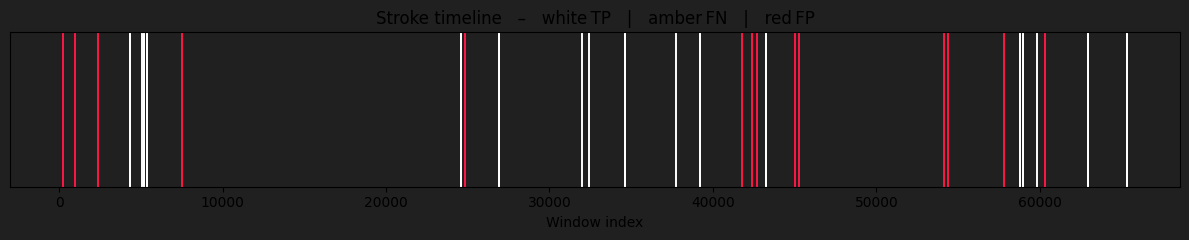

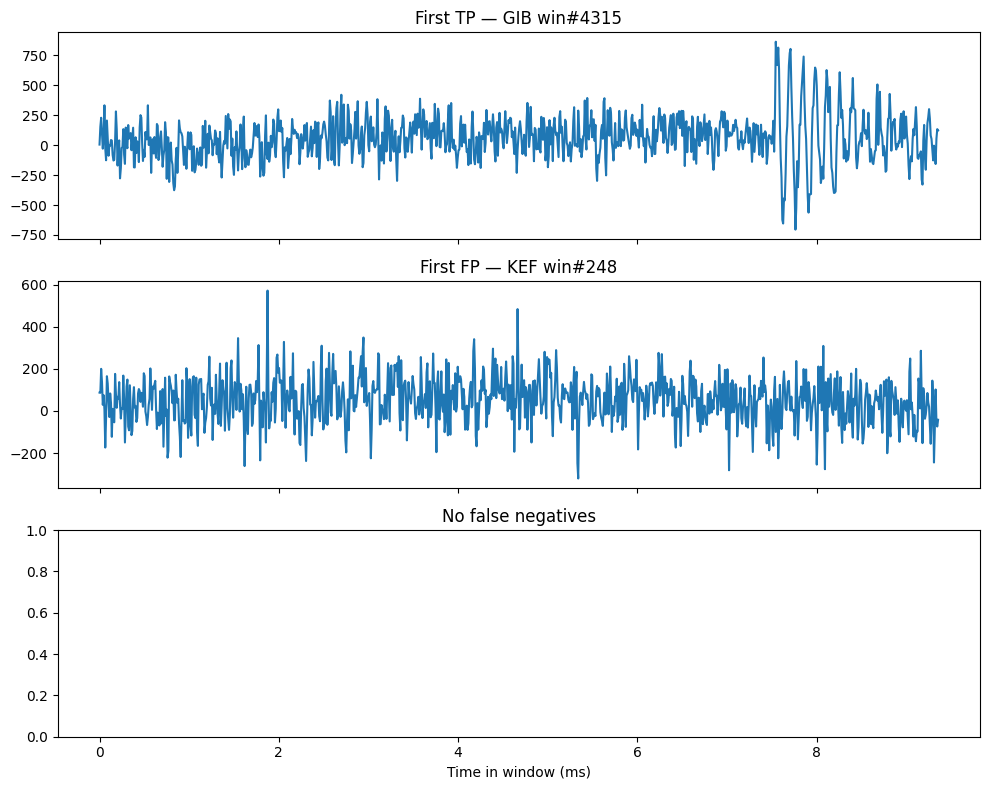


—— Station / window metrics  (n_windows = 67,688) ——
KEF: TP=  1 FP= 101 FN=244 P=0.010 R=0.004 F1=0.006
VAL: TP= 20 FP=  82 FN=225 P=0.196 R=0.082 F1=0.115
LER: TP=  1 FP=  67 FN=243 P=0.015 R=0.004 F1=0.006
HER: TP= 16 FP=  86 FN=228 P=0.157 R=0.066 F1=0.092
GIB: TP= 66 FP=  36 FN=181 P=0.647 R=0.267 F1=0.378
AKR: TP=  0 FP= 102 FN=245 P=0.000 R=0.000 F1=0.000
CAM: TP= 48 FP=  54 FN=195 P=0.471 R=0.198 F1=0.278
WAT: TP= 31 FP=  71 FN=215 P=0.304 R=0.126 F1=0.178
CAB: TP= 22 FP=  80 FN=225 P=0.216 R=0.089 F1=0.126
PAY: TP= 35 FP=  67 FN=209 P=0.343 R=0.143 F1=0.202
TAR: TP=  0 FP= 102 FN=247 P=0.000 R=0.000 F1=0.000

—— Network / stroke metrics ——
{'TP': 49, 'FP': 14, 'FN': 0, 'TN': 0, 'P': 0.778, 'R': 1.0, 'F1': 0.875}


In [10]:
# ======================================================================
# Isolation‑Forest detector – clean notebook cell
# ----------------------------------------------------------------------
# Needs:
#   • storm_data, cfg                         (StormGenerator cell)
#   • FeatureExtractor, make_windows, "iso16" (registry now extended)
#   • EvalConfig, evaluate_windowed_model     (evaluator cell)
# ======================================================================

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from typing import Dict

class IsoForestModel:
    def __init__(self, *, win=1024, hop=512,
                 contamination=0.001, n_trees=150,
                 contam_map: Dict[str,float]|None=None,
                 random_state=42):
        self.win = win; self.hop = hop
        self.contam = contamination
        self.contam_map = contam_map or {}
        self.n_trees = n_trees; self.rs = random_state
        self.fx = FeatureExtractor(["iso16"])
        self.models: Dict[str, tuple] = {}  # station → (scaler, forest)

    # ---- training -----------------------------------------------------
    def fit(self, raw: Dict[str,np.ndarray], fs:int, verbose=True):
        feats, _ = self.fx.transform(raw, win=self.win, hop=self.hop, fs=fs)
        for nm, X in feats.items():
            scaler = RobustScaler().fit(X)
            contam = self.contam_map.get(nm, self.contam)
            iso = IsolationForest(
                    n_estimators = self.n_trees,
                    contamination= contam,
                    random_state = self.rs
                 ).fit(scaler.transform(X))
            self.models[nm] = (scaler, iso, contam)
            if verbose:
                n_hot = int((iso.predict(scaler.transform(X))==-1).sum())
                print(f"{nm}: windows flagged = {n_hot:5d} / {len(X)}  "
                      f"(contam {contam:.3%})")

    # ---- inference ----------------------------------------------------
    def predict(self, raw: Dict[str,np.ndarray], fs:int) -> Dict[str,np.ndarray]:
        feats, _ = self.fx.transform(raw, win=self.win, hop=self.hop, fs=fs)
        out = {}
        for nm, X in feats.items():
            scaler, iso, _ = self.models[nm]
            out[nm] = iso.predict(scaler.transform(X)) == -1
        return out

# ----------------------------------------------------------------------
# 1.  Instantiate & fit
# ----------------------------------------------------------------------
WIN, HOP = 1024, 512
contam_override = {"LON": 0.001, "LER": 0.001,  # replicate inline logic
                   # others default to 0.0015 (=1.5×BASE_CONT)
                  }
model_iso = IsoForestModel(win=WIN, hop=HOP,
                           contamination=0.0015,
                           contam_map=contam_override,
                           n_trees=150)

print("\n▶ Fitting Isolation‑Forest detectors …")
model_iso.fit(storm_data.quantised, fs=cfg.fs)

# ----------------------------------------------------------------------
# 2.  Predict
# ----------------------------------------------------------------------
print("\n▶ Predicting hot windows …")
hot_iso = model_iso.predict(storm_data.quantised, fs=cfg.fs)

# ----------------------------------------------------------------------
# 3.  Evaluate
# ----------------------------------------------------------------------
eval_cfg = EvalConfig(win=WIN, hop=HOP, fs=cfg.fs,
                      burst_len=int(0.04*cfg.fs),
                      min_stn=2, tol_win=0)

station_m_iso, net_m_iso, n_win_iso = evaluate_windowed_model(
    hot            = hot_iso,
    stroke_records = storm_data.stroke_records,
    quantized      = storm_data.quantised,
    station_order  = list(storm_data.quantised),
    cfg            = eval_cfg,
    plot           = True
)

# ----------------------------------------------------------------------
# 4.  Summary
# ----------------------------------------------------------------------
print(f"\n—— Station / window metrics  (n_windows = {n_win_iso:,}) ——")
for nm,m in station_m_iso.items():
    print(f"{nm}: TP={m['TP']:3d} FP={m['FP']:4d} FN={m['FN']:3d} "
          f"P={m['P']:.3f} R={m['R']:.3f} F1={m['F1']:.3f}")

print("\n—— Network / stroke metrics ——")
print(net_m_iso)



▶ Training CDAE for KEF  (67688 windows, device=cpu)
  windows flagged =    68 (0.10 %)  |  thr=2.2834e-05

▶ Training CDAE for VAL  (67688 windows, device=cpu)
  windows flagged =    68 (0.10 %)  |  thr=2.8098e-05

▶ Training CDAE for LER  (67688 windows, device=cpu)
  windows flagged =    68 (0.10 %)  |  thr=3.3863e-05

▶ Training CDAE for HER  (67688 windows, device=cpu)
  windows flagged =    68 (0.10 %)  |  thr=4.1479e-05

▶ Training CDAE for GIB  (67688 windows, device=cpu)
  windows flagged =    68 (0.10 %)  |  thr=2.3003e-05

▶ Training CDAE for AKR  (67688 windows, device=cpu)
  windows flagged =    68 (0.10 %)  |  thr=2.0244e-05

▶ Training CDAE for CAM  (67688 windows, device=cpu)
  windows flagged =    68 (0.10 %)  |  thr=1.3218e-05

▶ Training CDAE for WAT  (67688 windows, device=cpu)
  windows flagged =    68 (0.10 %)  |  thr=1.7362e-05

▶ Training CDAE for CAB  (67688 windows, device=cpu)
  windows flagged =    68 (0.10 %)  |  thr=2.0398e-05

▶ Training CDAE for PAY  (6

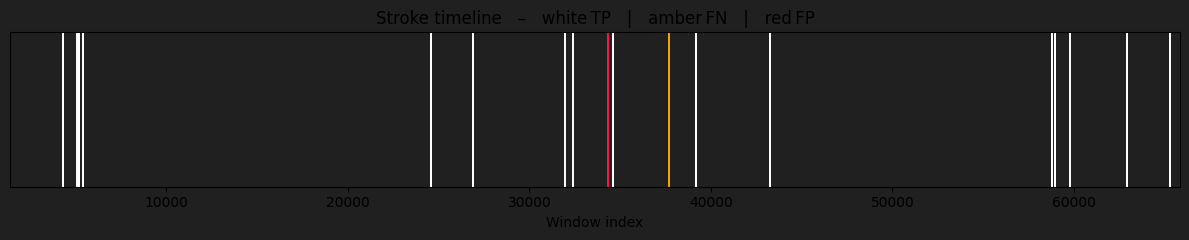

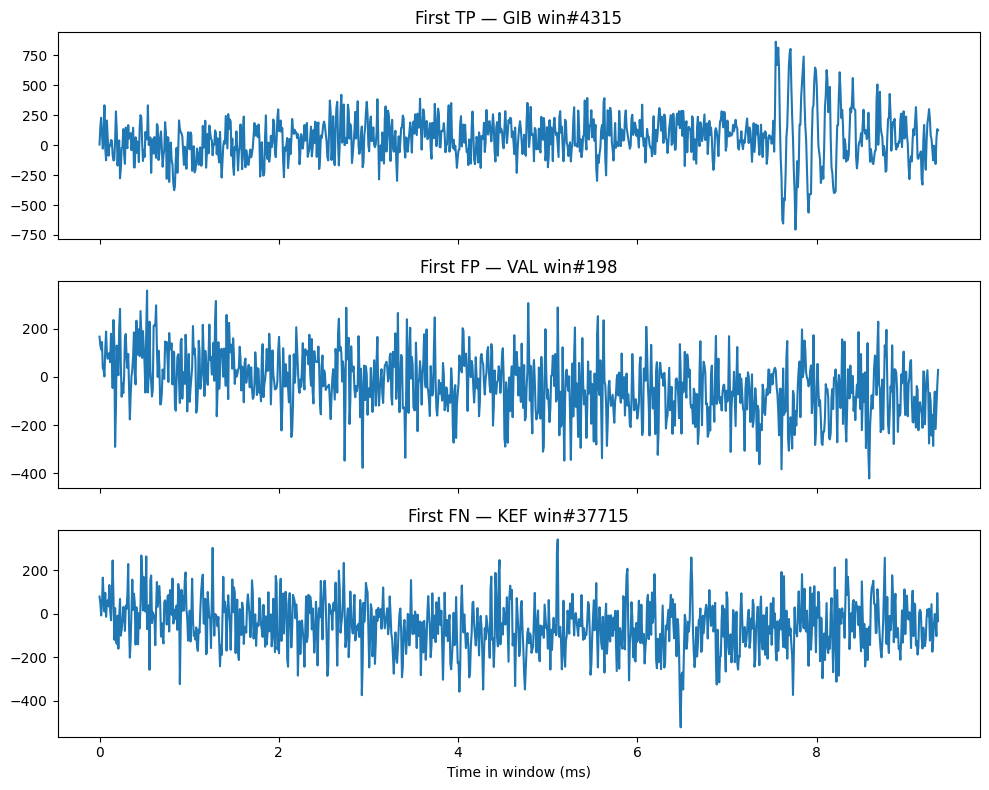


—— Station / window metrics  (n_windows = 67,688) ——
KEF: TP=  0 FP=  68 FN=245 P=0.000 R=0.000 F1=0.000
VAL: TP= 12 FP=  56 FN=233 P=0.176 R=0.049 F1=0.077
LER: TP=  1 FP=  67 FN=243 P=0.015 R=0.004 F1=0.006
HER: TP=  8 FP=  60 FN=236 P=0.118 R=0.033 F1=0.051
GIB: TP= 67 FP=   1 FN=180 P=0.985 R=0.271 F1=0.425
AKR: TP=  1 FP=  67 FN=244 P=0.015 R=0.004 F1=0.006
CAM: TP= 33 FP=  35 FN=210 P=0.485 R=0.136 F1=0.212
WAT: TP= 16 FP=  52 FN=230 P=0.235 R=0.065 F1=0.102
CAB: TP=  9 FP=  59 FN=238 P=0.132 R=0.036 F1=0.057
PAY: TP= 29 FP=  39 FN=215 P=0.426 R=0.119 F1=0.186
TAR: TP=  0 FP=  68 FN=247 P=0.000 R=0.000 F1=0.000

—— Network / stroke metrics ——
{'TP': 48, 'FP': 1, 'FN': 1, 'TN': 0, 'P': 0.98, 'R': 0.98, 'F1': 0.98}


In [11]:
# ======================================================================
# Convolutional Denoising Auto‑Encoder detector (model 6)
# ----------------------------------------------------------------------
# Requires:
#   • storm_data, cfg               (StormGenerator cell)
#   • make_windows                  (feature registry cell)
#   • evaluate_windowed_model, EvalConfig  (evaluator cell)
# ======================================================================

# from lightning_sim.features.basic import make_windows
# from lightning_sim.evaluation.scorer import evaluate_windowed_model, EvalConfig

import math, random, numpy as np, torch, torch.nn as nn, os
from torch.utils.data import DataLoader, Dataset
from typing import Dict

# ----------------------- tiny helpers ---------------------------------
class _WinDataset(Dataset):
    def __init__(self, win_mat: np.ndarray, noise_std=0.02):
        x = win_mat.astype(np.float32)/32768.0
        self.clean = torch.from_numpy(x)[:,None]
        self.noise_std = noise_std
    def __len__(self): return len(self.clean)
    def __getitem__(self, i):
        clean = self.clean[i]
        noisy = clean + self.noise_std*torch.randn_like(clean)
        return noisy, clean

class _CDAE(nn.Module):
    def __init__(self, latent=32):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv1d(1,  8, 7, 2, 3), nn.ReLU(),
            nn.Conv1d(8, 16, 7, 2, 3), nn.ReLU(),
            nn.Conv1d(16,32,7, 2, 3), nn.ReLU(),
            nn.Flatten(), nn.Linear(32*128, latent), nn.ReLU()
        )
        self.dec_fc = nn.Linear(latent, 32*128)
        self.dec = nn.Sequential(
            nn.ConvTranspose1d(32,16,7,2,3,output_padding=1), nn.ReLU(),
            nn.ConvTranspose1d(16,8,7,2,3,output_padding=1),  nn.ReLU(),
            nn.ConvTranspose1d(8,1,7,2,3,output_padding=1)
        )
    def forward(self, x):
        z = self.enc(x)
        h = self.dec_fc(z).view(-1,32,128)
        return self.dec(h)

# ----------------------- detector class -------------------------------
class CdaeModel:
    def __init__(self, *,
                 win=1024, hop=512,
                 latent=32, epochs=4, batch=256,
                 train_win=20_000, pct_thr=99.9,
                 device=None):
        self.win, self.hop = win, hop
        self.latent   = latent
        self.epochs   = epochs
        self.batch    = batch
        self.train_win= train_win
        self.pct_thr  = pct_thr
        self.device   = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.models: Dict[str, _CDAE] = {}
        self.thr:    Dict[str, float] = {}

    # ------------------------------------------------------------------
    def _train_one(self, win_mat: np.ndarray):
        idx = np.random.choice(len(win_mat),
                               min(self.train_win, len(win_mat)),
                               replace=False)
        ds = _WinDataset(win_mat[idx])
        dl = DataLoader(ds, batch_size=self.batch, shuffle=True,
                        num_workers=0, pin_memory=False)
        net = _CDAE(latent=self.latent).to(self.device)
        opt = torch.optim.Adam(net.parameters(), lr=1e-3)
        net.train()
        for _ in range(self.epochs):
            for noisy, clean in dl:
                noisy, clean = noisy.to(self.device), clean.to(self.device)
                opt.zero_grad()
                loss = nn.functional.mse_loss(net(noisy), clean)
                loss.backward(); opt.step()
        return net

    # ------------------------------------------------------------------
    def fit(self, raw: Dict[str,np.ndarray], verbose=True):
        for nm, sig in raw.items():
            win_mat = make_windows(sig, self.win, self.hop)
            if verbose:
                print(f"\n▶ Training CDAE for {nm}  "
                      f"({len(win_mat)} windows, device={self.device})")
            net = self._train_one(win_mat)
            self.models[nm] = net.eval()

            # inference to derive threshold
            errs = self._score_windows(net, win_mat)
            thr  = np.percentile(errs, self.pct_thr)
            self.thr[nm] = thr
            if verbose:
                n_hot = int((errs>thr).sum())
                print(f"  windows flagged = {n_hot:5d} "
                      f"({100*n_hot/len(errs):.2f} %)  |  thr={thr:.4e}")

    # ------------------------------------------------------------------
    def _score_windows(self, net: _CDAE, win_mat: np.ndarray) -> np.ndarray:
        errs = np.empty(len(win_mat), float)
        with torch.no_grad():
            for i0 in range(0, len(win_mat), 4096):
                seg = torch.from_numpy(
                        win_mat[i0:i0+4096].astype(np.float32)/32768.0
                     )[:,None].to(self.device)
                rec = net(seg).cpu().numpy()
                errs[i0:i0+len(rec)] = ((rec - seg.cpu().numpy())**2)\
                                        .mean(axis=(1,2))
        return errs

    # ------------------------------------------------------------------
    def predict(self, raw: Dict[str,np.ndarray]) -> Dict[str,np.ndarray]:
        hot = {}
        for nm, sig in raw.items():
            win_mat = make_windows(sig, self.win, self.hop)
            errs = self._score_windows(self.models[nm], win_mat)
            hot[nm] = errs > self.thr[nm]
        return hot

# ----------------------------------------------------------------------
# 1.  Instantiate & train
# ----------------------------------------------------------------------
WIN, HOP = 1024, 512
model_cdae = CdaeModel(win=WIN, hop=HOP,
                       latent=32, epochs=4, batch=256,
                       train_win=20_000, pct_thr=99.9)

model_cdae.fit(storm_data.quantised)

# ----------------------------------------------------------------------
# 2.  Predict hot windows
# ----------------------------------------------------------------------
hot_cdae = model_cdae.predict(storm_data.quantised)

# ----------------------------------------------------------------------
# 3.  Evaluate
# ----------------------------------------------------------------------
eval_cfg = EvalConfig(win=WIN, hop=HOP, fs=cfg.fs,
                      burst_len=int(0.04*cfg.fs),
                      min_stn=2, tol_win=0)

station_m_cdae, net_m_cdae, n_win_cdae = evaluate_windowed_model(
    hot            = hot_cdae,
    stroke_records = storm_data.stroke_records,
    quantized      = storm_data.quantised,
    station_order  = list(storm_data.quantised),
    cfg            = eval_cfg,
    plot           = True
)

# ----------------------------------------------------------------------
# 4.  Summary
# ----------------------------------------------------------------------
print(f"\n—— Station / window metrics  (n_windows = {n_win_cdae:,}) ——")
for nm, m in station_m_cdae.items():
    print(f"{nm}: TP={m['TP']:3d} FP={m['FP']:4d} FN={m['FN']:3d} "
          f"P={m['P']:.3f} R={m['R']:.3f} F1={m['F1']:.3f}")

print("\n—— Network / stroke metrics ——")
print(net_m_cdae)


In [ ]:

# ======================================================================
# Graph Auto‑Encoder lightning detector  (model 7, notebook version)
# ----------------------------------------------------------------------
# Relies on existing cells:
#   • StormGenerator / storm_data / cfg
#   • make_windows + FeatureExtractor  (feature "ae10" registered)
#   • EvalConfig, evaluate_windowed_model
#   • PyTorch Geometric installed
# ======================================================================

import numpy as np, torch, torch.nn as nn, torch.nn.functional as F, math
from torch_geometric.nn import GATv2Conv
from torch.utils.data import DataLoader, Dataset
from scipy.signal import hilbert, convolve

torch.manual_seed(42); np.random.seed(42)

# ---------------- configuration ---------------------------------------
WIN, HOP  = 1024, 512
STN       = list(storm_data.quantised)             # preserve generator order
FS        = float(cfg.fs)
LAT_NODE  = 64
EPOCHS    = 10
BATCH     = 512
LR        = 2e-3
ROBUST_K  = 4.0
MIN_STN   = 2
DEVICE    = 'cuda' if torch.cuda.is_available() else 'cpu'
BURST_LEN = int(0.04 * FS)

# ---------------- geography helper ------------------------------------
stations = StormGenerator._stations               # single authoritative copy

lats = np.array([stations[n]['lat'] for n in STN])
lons = np.array([stations[n]['lon'] for n in STN])
lat0, lon0 = lats.mean(), lons.mean()
lat_rng, lon_rng = np.ptp(lats - lat0) + 1e-6, np.ptp(lons - lon0) + 1e-6
coords = np.stack([(lats - lat0) / lat_rng,
                   (lons - lon0) / lon_rng], axis=1).astype(np.float32)

# edge index & 3‑D attributes (normalised distance, inverse distance, delay)
edge_src, edge_dst = zip(*[(i, j) for i in range(len(STN))
                           for j in range(len(STN)) if i != j])
edge_index = torch.tensor([edge_src, edge_dst],
                          dtype=torch.long, device=DEVICE)

dkm = np.array([[StormGenerator._hav(lats[i], lons[i], lats[j], lons[j])
                 for j in range(len(STN))] for i in range(len(STN))],
               np.float32)
d_n   = dkm / dkm.max()
inv_d = 1 / (dkm + 1e-3)
delay = (dkm / 300_000.0 * FS) / HOP
edge_attr = torch.tensor([[d_n[i, j], inv_d[i, j], delay[i, j]]
                          for i, j in zip(edge_src, edge_dst)],
                         dtype=torch.float32, device=DEVICE)

# ---------------- windowed data & node features -----------------------
def build_tensors(raw):
    """Return raw‑signal tensor and 12‑D node‑feature tensor."""
    win_mats = {n: make_windows(sig, WIN, HOP) for n, sig in raw.items()}
    n_win = min(mat.shape[0] for mat in win_mats.values())
    win_mats = {n: mat[:n_win] for n, mat in win_mats.items()}

    raw_t   = np.stack([win_mats[n] for n in STN], axis=1).astype(np.float32) / 32768.0

    fx = FeatureExtractor(["ae10"])
    feat_dict, _ = fx.transform(raw, win=WIN, hop=HOP, fs=cfg.fs)
    feat_t  = np.stack([feat_dict[n][:n_win] for n in STN], axis=1).astype(np.float32)

    coord_tile = np.tile(coords[None, :, :], (n_win, 1, 1))
    node_t = np.concatenate([feat_t, coord_tile], axis=2)  # (n_win, S, 12)
    return raw_t, node_t, n_win

raw_tensor, node_tensor, N_WIN = build_tensors(storm_data.quantised)

# unsupervised train subset (lowest‑energy 95 %)
peak_env = np.array([np.abs(hilbert(storm_data.quantised[STN[0]].astype(float)))
                     [w * HOP: w * HOP + WIN].max() for w in range(N_WIN)])
train_idx = np.where(peak_env < np.percentile(peak_env, 95))[0]

class WinDS(Dataset):
    def __len__(self): return len(train_idx)
    def __getitem__(self, k):
        i = train_idx[k]
        return (torch.from_numpy(node_tensor[i]).to(DEVICE),
                torch.from_numpy(raw_tensor[i]).to(DEVICE))
dl = DataLoader(WinDS(), batch_size=BATCH, shuffle=True, drop_last=True)

# ---------------- Graph Auto‑Encoder model ----------------------------
class GATBlock(nn.Module):
    def __init__(self, h):
        super().__init__()
        self.gat = GATv2Conv(h, h, heads=8, concat=False, edge_dim=3)
        self.norm = nn.LayerNorm(h)
    def forward(self, x, ei, ea):
        return self.norm(x + F.relu(self.gat(x, ei, ea)))

class GraphAE(nn.Module):
    def __init__(self, in_dim=12, latent=64):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(in_dim, 96), nn.ReLU(),
                                 nn.Linear(96, latent))
        self.gnn = nn.Sequential(GATBlock(latent), GATBlock(latent), GATBlock(latent))
        self.dec = nn.Sequential(nn.Linear(latent, 256), nn.ReLU(),
                                 nn.Linear(256, WIN))
    def forward(self, x, ei, ea):
        z = self.enc(x)
        for blk in self.gnn: z = blk(z, ei, ea)
        return self.dec(z)

model = GraphAE(latent=LAT_NODE).to(DEVICE)
opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
loss_fn = nn.MSELoss()

print(f"\n▶ Training Graph‑AE on {DEVICE} "
      f"(windows={len(train_idx)}, epochs={EPOCHS}, batch={BATCH})")
for ep in range(1, EPOCHS + 1):
    acc_loss = 0.0
    for Xn, Raw in dl:
        B = Xn.size(0)
        out = model(Xn.view(B * len(STN), 12), edge_index, edge_attr)
        loss = loss_fn(out, Raw.view(B * len(STN), WIN))
        opt.zero_grad(); loss.backward(); opt.step()
        acc_loss += loss.item() * B
    print(f"  ep{ep:02d}: mean‑MSE = {acc_loss / (len(dl) * B):.4e}")

# ---------------- score all windows ----------------------------------
err = np.empty((N_WIN, len(STN)), np.float32)
model.eval(); torch.set_grad_enabled(False)
STEP = 2048
for s in range(0, N_WIN, STEP):
    e = min(N_WIN, s + STEP); B = e - s
    Xb = torch.from_numpy(node_tensor[s:e]).to(DEVICE)
    Raw = torch.from_numpy(raw_tensor[s:e]).to(DEVICE)
    rec = model(Xb.view(B * len(STN), 12), edge_index, edge_attr
               ).cpu().numpy().reshape(B, len(STN), WIN)
    err[s:e] = ((rec - Raw.cpu().numpy()) ** 2).mean(axis=2)

# ---------------- robust threshold & simple suppression ---------------
hot = {}
for i, nm in enumerate(STN):
    e   = err[:, i]
    med = np.median(e); mad = np.median(np.abs(e - med)) + 1e-9
    hot[nm] = (e - med) / mad > ROBUST_K
    print(f"{nm}: raw‑flagged = {hot[nm].sum()}")

# majority smoothing (±1 window) + neighbour consensus
ker = np.array([1, 1, 1], int)
for nm in STN:
    sm = convolve(hot[nm].astype(int), ker, mode="same")
    hot[nm] = sm >= 2
stack = np.stack([hot[n] for n in STN])
neigh = np.pad(stack, ((0, 0), (1, 1)), 'constant')
neigh = neigh[:, :-2] + stack + neigh[:, 2:]
for i, nm in enumerate(STN):
    hot[nm] &= (neigh.sum(axis=0) - neigh[i]) >= 1

print("\n▶ After suppression:")
for nm in STN:
    print(f"  {nm}: final‑flagged = {hot[nm].sum()}")

# ---------------- strict evaluation ----------------------------------
eval_cfg = EvalConfig(win=WIN, hop=HOP, fs=cfg.fs,
                      burst_len=BURST_LEN, min_stn=MIN_STN, tol_win=0)

station_m_gnn, net_m_gnn, _ = evaluate_windowed_model(
    hot            = hot,
    stroke_records = storm_data.stroke_records,
    quantized      = storm_data.quantised,
    station_order  = STN,
    cfg            = eval_cfg,
    plot           = True
)

print("\n—— Station‑level window metrics ——")
for nm, m in station_m_gnn.items():
    print(f"{nm}: TP={m['TP']:3d} FP={m['FP']:4d} FN={m['FN']:3d} "
          f"P={m['P']:.3f} R={m['R']:.3f} F1={m['F1']:.3f}")

print("\n—— Network‑level stroke metrics ——")
print(net_m_gnn)


In [ ]:
# ======================================================================
# 1‑D Dilated‑TCN Auto‑Encoder lightning detector (model 8)
# ----------------------------------------------------------------------
# Relies on utilities already defined in earlier cells (see header note).
# ======================================================================

import math, random, numpy as np, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

# ---------------- configuration ---------------------------------------
WIN, HOP   = 1024, 512
CHANNELS   = [16, 32, 64]
KERNEL     = 7
LATENT     = 64
DROPOUT    = 0.10
EPOCHS     = 5
BATCH      = 256
TRAIN_FRAC = 0.40           # fraction of windows used for AE training
PCT_THR    = 99.9           # percentile threshold on reconstruction RMSE
MIN_STN    = 2
TOL_WIN    = 1
FS         = float(cfg.fs)
BURST_LEN  = int(0.04 * FS)
STN        = list(storm_data.quantised)   # keep station order

# ---------------- device & reproducibility ----------------------------
if torch.backends.mps.is_available():
    DEVICE = "mps"
elif torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

torch.manual_seed(42); random.seed(42); np.random.seed(42)

use_amp    = (DEVICE == "cuda")
do_compile = (DEVICE == "cuda" and hasattr(torch, "compile"))

# ---------------- build sliding‑window matrices once ------------------
# (reuse make_windows from the feature‑registry cell – no duplication)
win_mats = {nm: make_windows(sig, WIN, HOP) for nm, sig in storm_data.quantised.items()}
n_win_global = min(mat.shape[0] for mat in win_mats.values())

# ---------------------------------------------------------------------
# 2.  Dataset helper
# ---------------------------------------------------------------------
class WinDataset(Dataset):
    def __init__(self, wins: np.ndarray):
        w = wins.astype(np.float32) / 32768.0
        self.w = w[:, None, :]                      # (N,1,WIN)
    def __len__(self):  return self.w.shape[0]
    def __getitem__(self, i):  return torch.from_numpy(self.w[i])

# ---------------------------------------------------------------------
# 3.  Dilated‑TCN Auto‑Encoder
# ---------------------------------------------------------------------
class DilatedConvBlock(nn.Module):
    def __init__(self, cin, cout, k, dil, drop):
        super().__init__()
        pad = (k - 1) * dil // 2
        self.conv = nn.Conv1d(cin, cout, k, padding=pad, dilation=dil)
        self.act  = nn.ReLU()
        self.drop = nn.Dropout(drop)
        self.res  = nn.Conv1d(cin, cout, 1) if cin != cout else nn.Identity()
    def forward(self, x):
        y = self.act(self.conv(x))
        return self.res(x) + self.drop(y)

class TCNEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        blocks, cin = [], 1
        for i, c in enumerate(CHANNELS):
            blocks.append(DilatedConvBlock(cin, c, KERNEL, 2 ** i, DROPOUT))
            cin = c
        self.net = nn.Sequential(*blocks)
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc  = nn.Linear(CHANNELS[-1], LATENT)
    def forward(self, x):
        h = self.net(x)
        z = self.gap(h).squeeze(-1)
        return self.fc(z)

class TCNDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(LATENT, CHANNELS[-1])
        rev = CHANNELS[::-1]         # e.g. 64‑32‑16
        blocks, cin = [], rev[0]
        for i, c in enumerate(rev[1:] + [1]):      # last block → 1 channel
            blocks.append(DilatedConvBlock(cin, c, KERNEL, 2 ** i, DROPOUT))
            cin = c
        self.net = nn.Sequential(*blocks)
    def forward(self, z):
        h = self.fc(z)[:, :, None].repeat(1, 1, WIN)
        return torch.tanh(self.net(h))

class TCN_AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = TCNEncoder()
        self.dec = TCNDecoder()
    def forward(self, x):
        z = self.enc(x)
        return self.dec(z)

# ---------------------------------------------------------------------
# 4.  Train one AE per station & generate hot masks
# ---------------------------------------------------------------------
recon_err, hot_masks = {}, {}

for nm in STN:
    print(f"\n=== {nm}  (device={DEVICE}) ===")
    wins_all = win_mats[nm][:n_win_global]
    n_win    = wins_all.shape[0]

    # ----- training subset -------------------------------------------
    idx_train = np.random.choice(n_win, int(TRAIN_FRAC * n_win), replace=False)
    dl_train  = DataLoader(WinDataset(wins_all[idx_train]),
                           batch_size=BATCH, shuffle=True)

    # ----- model & optimiser -----------------------------------------
    model = TCN_AE().to(DEVICE)
    if do_compile:
        model = torch.compile(model)
    opt      = torch.optim.AdamW(model.parameters(), lr=3e-3)
    loss_fn  = nn.MSELoss()
    scaler   = torch.cuda.amp.GradScaler() if use_amp else None

    # ----- training loop ---------------------------------------------
    model.train()
    for ep in range(1, EPOCHS + 1):
        pbar = tqdm(dl_train, desc=f"{nm}  epoch {ep}/{EPOCHS}", leave=False)
        for xb in pbar:
            xb = xb.to(DEVICE)
            opt.zero_grad()
            if use_amp:
                with torch.cuda.amp.autocast():
                    recon = model(xb)
                    loss  = loss_fn(recon, xb)
                scaler.scale(loss).backward()
                scaler.step(opt); scaler.update()
            else:
                recon = model(xb)
                loss  = loss_fn(recon, xb)
                loss.backward(); opt.step()
            pbar.set_postfix(loss=float(loss))

    # ----- full‑set reconstruction RMSE ------------------------------
    model.eval(); torch.set_grad_enabled(False)
    errs = np.empty(n_win, np.float32)
    dl_all = DataLoader(WinDataset(wins_all), batch_size=BATCH)
    k = 0
    for xb in dl_all:
        xb = xb.to(DEVICE)
        if use_amp:
            with torch.cuda.amp.autocast():
                recon = model(xb)
        else:
            recon = model(xb)
        rmse = ((recon - xb) ** 2).mean((1, 2)).sqrt().cpu().numpy()
        errs[k:k + len(rmse)] = rmse;  k += len(rmse)

    thr = np.percentile(errs, PCT_THR)
    hot_masks[nm] = errs > thr
    recon_err[nm] = errs
    print(f"  threshold (RMSE) = {thr:.4f}   hot = {hot_masks[nm].sum():,}/{n_win:,}")

# ---------------------------------------------------------------------
# 5.  Strict evaluation
# ---------------------------------------------------------------------
eval_cfg = EvalConfig(win=WIN, hop=HOP, fs=FS,
                      burst_len=BURST_LEN,
                      min_stn=MIN_STN, tol_win=TOL_WIN)

station_m, net_m, n_win_eval = evaluate_windowed_model(
    hot            = hot_masks,
    stroke_records = storm_data.stroke_records,
    quantized      = storm_data.quantised,
    station_order  = STN,
    cfg            = eval_cfg,
    plot           = True
)

print(f"\nProcessed {n_win_eval} windows per station.")
for nm, m in station_m.items():
    print(f"{nm}: TP={m['TP']:4d}  FP={m['FP']:4d}  FN={m['FN']:4d}  "
          f"P={m['P']:.3f}  R={m['R']:.3f}  F1={m['F1']:.3f}")

print("\nNetwork metrics:", net_m)
